# Malicious Domain Dataset - Multi-layer Perceptron Classifier

In [85]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

# Load preprocessed dataset
datasource = "preprocessed.csv"
data = pd.read_csv(datasource)
data.Class.value_counts()

0    32613
1     3815
Name: Class, dtype: int64

## Resampling

As the preprocessed dataset is unbalanced, we resample to create a balanced set for training and testing.

In [86]:
from sklearn.utils import resample

sample_size = min(data.Class.value_counts())

malicious = resample(data.loc[data["Class"] == 0], replace=False, n_samples=sample_size, random_state=42)
benign = resample(data.loc[data["Class"] == 1], replace=False, n_samples=sample_size, random_state=42)

balanced = pd.concat([malicious, benign])
balanced.Class.value_counts()

X = balanced.drop(columns=["Class"])
y = balanced["Class"]

## Cross-validation

Here we assess how well an MLP classifier will generalize the dataset by performing 10-fold cross-validation.

In [87]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = MLPClassifier(max_iter=500)

stages = [("scaler", StandardScaler()), ("classifier", clf)]
pipeline = Pipeline(stages)

folds = 10
metrics = ["accuracy", "f1", "precision", "recall"]
scores = cross_validate(pipeline, X, y, scoring=metrics, cv=folds)

scores = pd.DataFrame.from_dict(scores)
scores

,fit_time,score_time,test_accuracy,test_f1,test_precision,test_recall
0,5.063642,0.004027,0.982962,0.983007,0.979167,0.986877
1,4.652098,0.004683,0.981651,0.981675,0.979112,0.984252
2,5.557061,0.004042,0.982962,0.983051,0.976684,0.989501
3,5.858310,0.003872,0.972477,0.972332,0.976190,0.968504
4,4.959116,0.003890,0.975098,0.975163,0.971354,0.979003
5,4.905289,0.004212,0.986894,0.986911,0.986911,0.986911
6,5.364337,0.003881,0.982962,0.983051,0.979221,0.986911
7,4.785631,0.003949,0.981651,0.981818,0.974227,0.989529
8,5.991479,0.004580,0.993447,0.993447,0.994751,0.992147
9,5.672817,0.004495,0.977720,0.977424,0.991914,0.963351


In [88]:
scores.mean()

fit_time          5.280978
score_time        0.004163
test_accuracy     0.981782
test_f1           0.981788
test_precision    0.980953
test_recall       0.982698
dtype: float64

## Finalized Model

In [89]:
clf = MLPClassifier(max_iter=500)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.4, random_state=42)

stages = [("scaler", StandardScaler()), ("classifier", clf)]
pipeline = Pipeline(stages)

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.9792485801660114

Note: For the above estimator the MLP hyperparameters were left as their default values. Using hyperparameter search methods the model could potentially be further improved.

### Visualizations

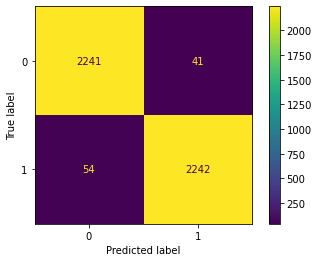

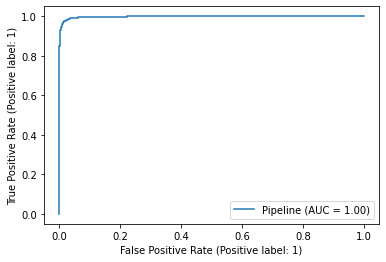

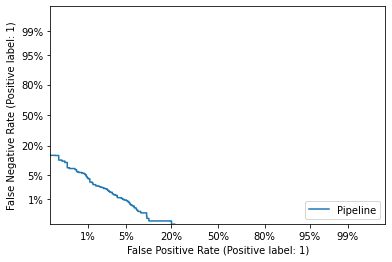

In [90]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, DetCurveDisplay

ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)

RocCurveDisplay.from_estimator(pipeline, X_test, y_test)

DetCurveDisplay.from_estimator(pipeline, X_test, y_test)